<a href="https://colab.research.google.com/github/moist234/ECON3916-Statistical-Machine-Learning/blob/main/Assignment%201/Econ_3916_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
student_basket = [
    {'Item': 'Tuition', 'Price_2016': 45000, 'Price_2024': 58000},
    {'Item': 'Rent (1 Bed)', 'Price_2016': 1200, 'Price_2024': 1800},
    {'Item': 'Chipotle Burrito', 'Price_2016': 7.50, 'Price_2024': 11.50},
    {'Item': 'Spotify', 'Price_2016': 9.99, 'Price_2024': 11.99},
]


def calculate_inflation(base, current):
    return ((current - base) / base) * 100

print("Student Basket Inflation (2016 -> 2024)")
for item in student_basket:
    rate = calculate_inflation(item['Price_2016'], item['Price_2024'])
    print(f"{item['Item']}: {rate:.2f}% Inflation")


Student Basket Inflation (2016 -> 2024)
Tuition: 28.89% Inflation
Rent (1 Bed): 50.00% Inflation
Chipotle Burrito: 53.33% Inflation
Spotify: 20.02% Inflation


In [64]:
!pip -q install fredapi

import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred

# Authenticate (replace with your real key)
fred = Fred(api_key="716ad6d9cbf7b67fb22389689afba051")

print("Fetching data from FRED...")

official_cpi = fred.get_series("CPIAUCSL")
tuition      = fred.get_series("CUSR0000SEEB")
rent         = fred.get_series("CUSR0000SEHA")
streaming    = fred.get_series("CUSR0000SERA02")
food_away    = fred.get_series("CUSR0000SEFV")

df = pd.DataFrame({
    "Official_CPI": official_cpi,
    "Tuition": tuition,
    "Rent": rent,
    "Streaming": streaming,
    "Food_Away_From_Home": food_away
})

df.index = pd.to_datetime(df.index)
df = df.dropna()

print(df.head())
print(df.tail())

Fetching data from FRED...
            Official_CPI  Tuition   Rent  Streaming  Food_Away_From_Home
1992-01-01         138.3    200.7  145.4      180.8                139.8
1992-02-01         138.6    201.9  145.7      181.8                140.0
1992-03-01         139.1    203.5  146.5      183.3                140.1
1992-04-01         139.4    205.0  146.2      186.2                140.2
1992-05-01         139.7    206.3  146.5      185.2                140.4
            Official_CPI  Tuition     Rent  Streaming  Food_Away_From_Home
2025-07-01       322.132  893.568  436.152    594.484              383.808
2025-08-01       323.364  895.305  437.462    592.604              384.909
2025-09-01       324.368  897.302  438.322    593.928              385.451
2025-11-01       325.031  902.001  438.875    599.226              387.202
2025-12-01       326.030  903.402  440.034    605.825              389.889


In [65]:

start_date = "2016-01-01"

# Use data starting 2016+
df_2016 = df.loc[start_date:]

# First row in 2016+ becomes the baseline
base = df_2016.iloc[0]

# Normalize each column so it starts at 100
df_norm = (df_2016 / base) * 100

print("Normalized data created (2016 start = 100)")
print(df_norm.head())

Normalized data created (2016 start = 100)
            Official_CPI     Tuition        Rent   Streaming  \
2016-01-01    100.000000  100.000000  100.000000  100.000000   
2016-02-01     99.867032  100.241572  100.314364  100.723912   
2016-03-01    100.180095  100.470288  100.607131  101.450163   
2016-04-01    100.563850  100.692146  100.924580  101.878663   
2016-05-01    100.801592  100.929861  101.258485  102.214306   

            Food_Away_From_Home  
2016-01-01           100.000000  
2016-02-01           100.138869  
2016-03-01           100.355827  
2016-04-01           100.599712  
2016-05-01           100.813978  


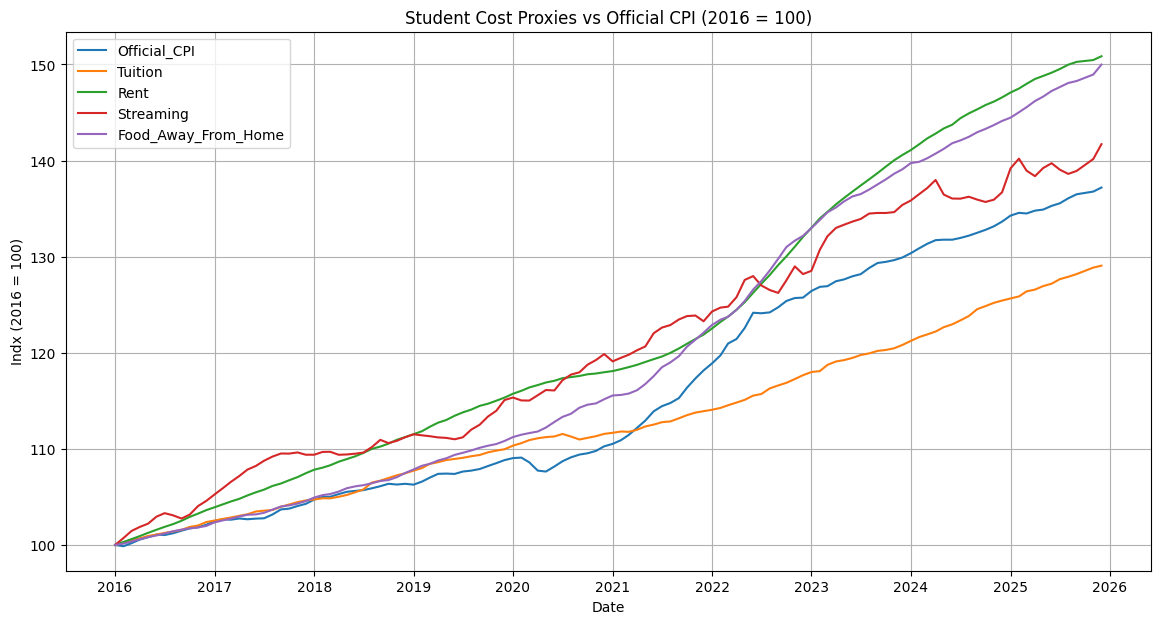

In [66]:
plt.figure(figsize=(14, 7))

for col in df_norm.columns:
    plt.plot(df_norm.index, df_norm[col], label=col)

plt.title("Student Cost Proxies vs Official CPI (2016 = 100)")
plt.xlabel("Date")
plt.ylabel("Indx (2016 = 100)")
plt.legend()
plt.grid(True)
plt.show()

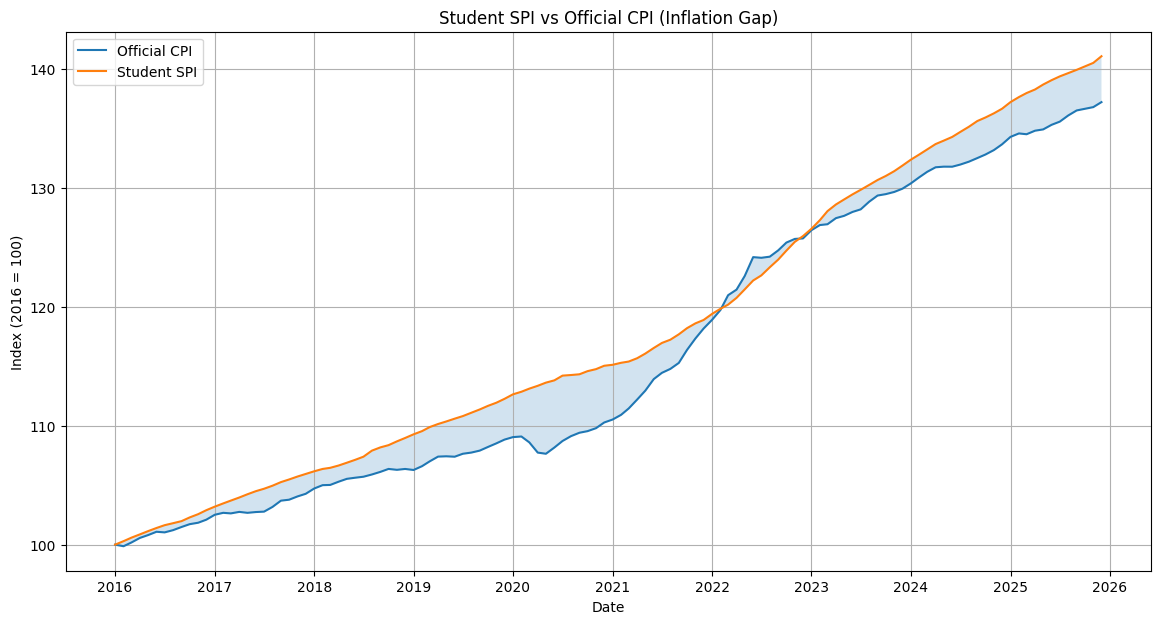

In [67]:
weights = {
    "Tuition": 0.40,
    "Rent": 0.30,
    "Food_Away_From_Home": 0.20,
    "Streaming": 0.10
}

df_norm["Student_SPI"] = 0
for k, w in weights.items():
    df_norm["Student_SPI"] += df_norm[k] * w

plt.figure(figsize=(14, 7))
plt.plot(df_norm.index, df_norm["Official_CPI"], label="Official CPI")
plt.plot(df_norm.index, df_norm["Student_SPI"], label="Student SPI")

plt.fill_between(
    df_norm.index,
    df_norm["Official_CPI"],
    df_norm["Student_SPI"],
    alpha=0.2
)

plt.title("Student SPI vs Official CPI (Inflation Gap)")
plt.xlabel("Date")
plt.ylabel("Index (2016 = 100)")
plt.legend()
plt.grid(True)
plt.show()

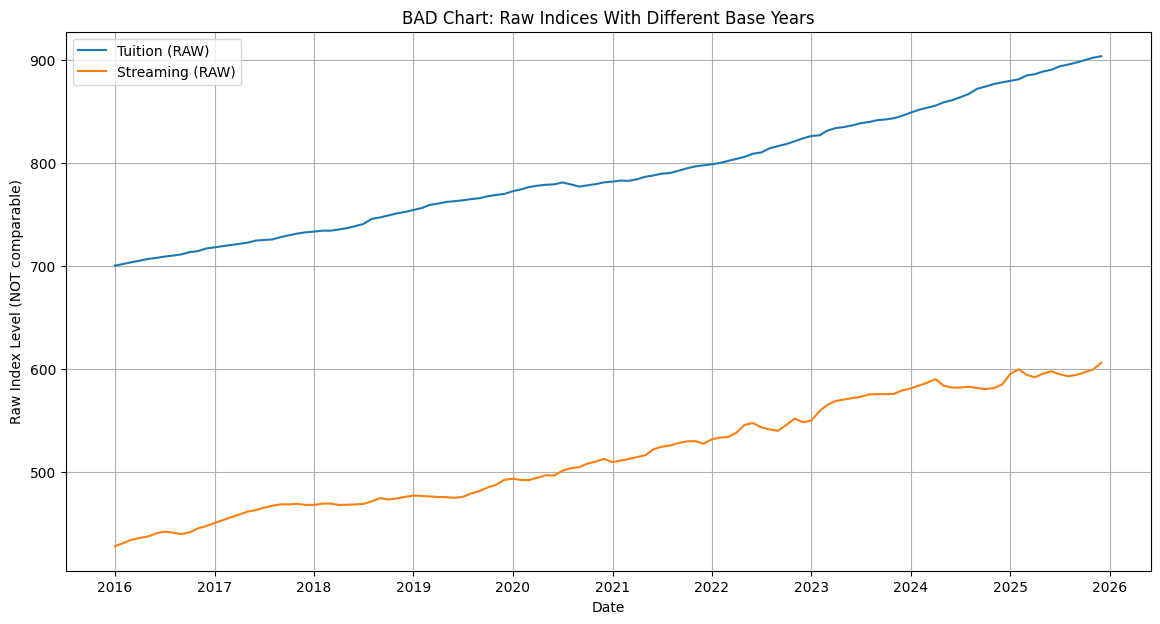

In [68]:
plt.figure(figsize=(14, 7))
plt.plot(df_2016.index, df_2016["Tuition"], label="Tuition (RAW)")
plt.plot(df_2016.index, df_2016["Streaming"], label="Streaming (RAW)")

plt.title("BAD Chart: Raw Indices With Different Base Years")
plt.xlabel("Date")
plt.ylabel("Raw Index Level (NOT comparable)")
plt.legend()
plt.grid(True)
plt.show()

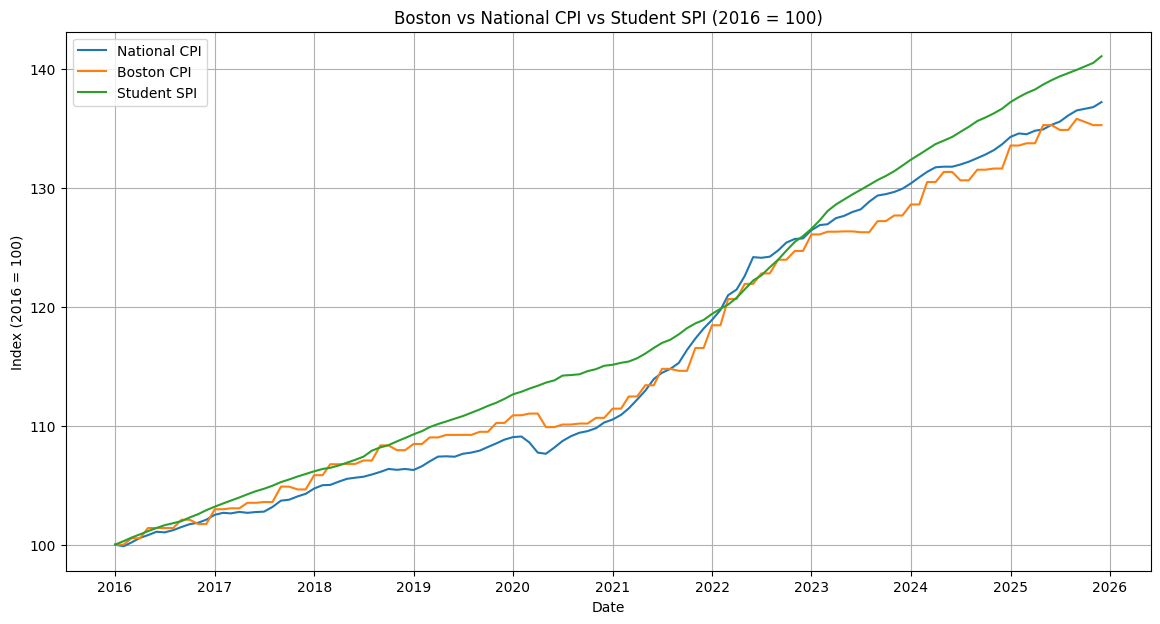

In [69]:
# 1) Fetch Boston CPI (FRED code: CUURA103SA0)
boston_cpi_raw = fred.get_series("CUURA103SA0")  # Boston-Cambridge-Newton CPI (All Items)
boston_cpi_raw.index = pd.to_datetime(boston_cpi_raw.index)

# 2) Put Boston series into a DataFrame
boston_df = pd.DataFrame({"Boston_CPI": boston_cpi_raw}).sort_index()

# 3) Align Boston to your existing df_norm dates
# (handles missing values if Boston is monthly/bimonthly or has gaps)
plot_df = df_norm[["Official_CPI", "Student_SPI"]].copy()
plot_df = plot_df.join(boston_df, how="left")

# 4) Normalize Boston to 2016 = 100 using the first available Boston value in 2016+
boston_2016 = plot_df.loc["2016-01-01":, "Boston_CPI"].dropna()
boston_base = boston_2016.iloc[0]
plot_df["Boston_CPI"] = (plot_df["Boston_CPI"] / boston_base) * 100

# Optional: fill small gaps so the line draws cleanly
plot_df["Boston_CPI"] = plot_df["Boston_CPI"].ffill()

# 5) Plot 3 lines
plt.figure(figsize=(14, 7))
plt.plot(plot_df.index, plot_df["Official_CPI"], label="National CPI")     # (Grey requested, but not forcing colors)
plt.plot(plot_df.index, plot_df["Boston_CPI"], label="Boston CPI")
plt.plot(plot_df.index, plot_df["Student_SPI"], label="Student SPI")

plt.title("Boston vs National CPI vs Student SPI (2016 = 100)")
plt.xlabel("Date")
plt.ylabel("Index (2016 = 100)")
plt.legend()
plt.grid(True)
plt.show()